# Experiments with textual misinformation detection using machine learning models
In this experiment, we train and test machine learning models for detecting misinformation based purely on the text. We evaluated the performance of 5 classification models with wide use in text classification problems.

**Models:**
* Logistic regression
* Bernoulli Naive-Bayes
* Multinomial Naive-Bayes
* Linear SVM
* KNN
* Random forest
* Gradient Boosting
* Multilayer Perceptron

# NOTES TO MYSELF

**To do:**
* handcrafted linguistic features
* ~~hyperparamater tunning; validation~~


**References:**
* https://towardsdatascience.com/text-classification-in-python-dd95d264c802
* https://github.com/miguelfzafra/Latest-News-Classifier/tree/master/0.%20Latest%20News%20Classifier/04.%20Model%20Training


In [7]:
#utils
import emoji, re, string, time, os
from utils import getTestMetrics
import pandas as pd
import numpy as np
from scipy.stats import randint
import pickle

#nlp
import nltk
from nltk.corpus import stopwords
import spacy

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns

#features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

#models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

#data balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

%matplotlib inline
sns.set(style="darkgrid")

start_time = time.time()

## Experiments

## Subsets:
* Viral
* All

### Feature engineering
* bow: binary bag of words
* tfidf: term frequency–inverse document frequency
* max_features: limits to 500

### Pre-processing
* processed: convert url in just the domain, separate emojis, remove punctuation, downcase, lemmatization, remove stop words

### Data balancing
* smote: Synthetic Minority Oversampling Technique
* undersampling: random undersampling
* random_oversampling


### Conclusions:
* Smote is not the best oversampling technique for text, specially for BOW features
* Pre-processing the data didn't appear to have a great impact, despite the great reduction of dimentionality
* BOW features are comparably to TF-IDF features
* Random oversampling is a good oversampling technique
* Use a maximum number of features wasn't a good approach

In [8]:
base = '2018'
subset = 'viral'
path_dir = 'results/' + str(base) + '/' + subset + '/ml/'
path_dir

'results/2018/viral/ml/'

In [15]:
# best results analysis
df_best = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1 score', 'auc score','vocab'])
#iterates over files
exp = []
for filename in os.listdir(path_dir):
    exp.append(str(filename).replace('.csv',''))
    file_path = path_dir + filename
    #print(filename)
    df_temp = pd.read_csv(file_path)
    best_ix = df_temp['f1 score'].argmax() #f1 score
    best = df_temp.iloc[best_ix]
    df_best = df_best.append(best)
df_best['experiment'] = exp
cols = df_best.columns.tolist()
cols = cols[-2:] + cols[:-2]
df_best = df_best[cols]
df_best = df_best.reset_index()
df_best = df_best.drop(columns = ['index'])
df_best = df_best.sort_values(by='f1 score',ascending=False)
df_best.style.background_gradient(cmap='Blues')

,vocab,experiment,model,accuracy,precision,recall,f1 score,auc score
10,21173,ml-tfidf-processed-smote,linear svm,0.789972,0.754098,0.733485,0.743649,0.000000
11,21173,ml-bow-processed-random_oversampling,logistic regression,0.794702,0.773399,0.715262,0.743195,0.848567
14,24442,ml-tfidf-random_oversampling,linear svm,0.788079,0.748268,0.738041,0.743119,0.000000
15,21173,ml-tfidf-processed-random_oversampling,mlp,0.783349,0.732301,0.753986,0.742985,0.860454
16,24442,ml-tfidf-smote,linear svm,0.787133,0.748837,0.733485,0.741082,0.000000
7,24442,ml-tfidf-undersampling,mlp,0.763482,0.682081,0.806378,0.739040,0.862386
5,24442,ml-tfidf,linear svm,0.789026,0.760870,0.717540,0.738570,0.000000
2,21173,ml-tfidf-processed,linear svm,0.789972,0.767901,0.708428,0.736967,0.000000
13,24442,ml-bow-random_oversampling,mlp,0.784295,0.759214,0.703872,0.730496,0.851358
3,24442,ml-bow,mlp,0.785241,0.763682,0.699317,0.730083,0.851892


# Begin experiment

In [16]:
pre_processed = True # the texts were already pre-processed
experiment = 'ml-tfidf-processed-random_oversampling'
filepath = 'data/' + str(base) + '/fakeWhatsApp.BR_' + str(base) + '.csv'
df = pd.read_csv(filepath)

if subset == 'viral':
    df = df[df['viral']==1]
    
df.head(5)

/home/cabral/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,url,characters,words,viral,sharings,text,misinformation
1,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,0,0,58,9,1,2,O Bolsonaro tem que estar preparado pra respon...,0
15,3631133147603888180,10/08/18,14:31,55,BRASIL,BRA,17,São Paulo,2018_1,0,0,99,18,1,2,"No dia 07 de Outubro, quando for votar, não es...",1
26,-4391661641377612003,11/08/18,19:28,55,BRASIL,BRA,13,São Paulo,2018_1,0,0,114,17,1,6,Devido a aborrecimentos nas varias redes socia...,0
43,3631133147603888180,15/08/18,19:23,55,BRASIL,BRA,17,São Paulo,2018_1,0,1,330,47,1,7,EU GOSTARIA DE PEDIR A TODOS DO GRUPOS ENTREM ...,0
103,-4391661641377612003,22/08/18,22:11,55,BRASIL,BRA,13,São Paulo,2018_1,0,0,226,39,1,8,Como são as coisas.\nChefe do jacaré aparece n...,1


# Corpus statistics

In [17]:
df.describe()[['characters','words','sharings']]

,characters,words,sharings
count,20872.000000,20872.000000,20872.000000
mean,530.377252,80.396560,11.232177
std,901.760873,138.349054,16.071484
min,23.000000,6.000000,2.000000
25%,108.000000,16.000000,2.000000
50%,202.000000,30.000000,5.000000
75%,482.000000,77.000000,12.000000
max,15683.000000,2664.000000,91.000000


In [18]:
texts = df[df['midia']==0]['text']
y = df[df['midia']==0]['misinformation']

total data


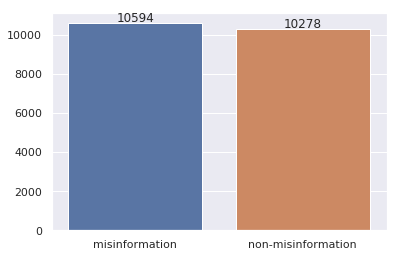

In [19]:
print('total data')
pos_mask = y == 1 
pos = y[pos_mask]
neg_mask = y == 0 
neg = y[neg_mask]
values = [pos.shape[0],neg.shape[0]]
keys = ['misinformation', 'non-misinformation']
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

data after remove duplicates


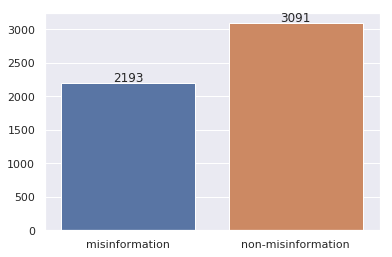

In [20]:
#removing duplicates
    
df = df.drop_duplicates(subset=['text'])    
texts = df[df['midia']==0]['text']
y = df[df['midia']==0]['misinformation']

print('data after remove duplicates')
pos_mask = y == 1 
pos = y[pos_mask]
neg_mask = y == 0 
neg = y[neg_mask]
values = [pos.shape[0],neg.shape[0]]
keys = ['misinformation', 'non-misinformation']
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

In [9]:
print(len(texts))
print(len(y))

5284
5284


# Pre-processing
* convert url in just the domain
* separate emojis
* punctuation

[Some suggestions in this work](https://github.com/miguelfzafra/Latest-News-Classifier/blob/master/0.%20Latest%20News%20Classifier/03.%20Feature%20Engineering/03.%20Feature%20Engineering.ipynb)

* **Special character cleaning**

* **Upcase/downcase**

* **Punctuation signs** 

* **Possessive pronouns**

* **Stemming or Lemmatization**

* **Stop words**

In [10]:
#emojis and punctuation
emojis_list = list(emoji.UNICODE_EMOJI.keys())
punct = list(string.punctuation)
emojis_punct = emojis_list + punct

def processEmojisPunctuation(text, remove_punct = True):
    '''
    Put spaces between emojis. Removes punctuation.
    '''
    #get all unique chars
    chars = set(text)
    #for each unique char in text, do:
    for c in chars:
        #remove punctuation
        if remove_punct:
            if c in emojis_list:
                text = text.replace(c, ' ' + c + ' ')
            if c in punct:
                text = text.replace(c, ' ')
                
        #put spaces between punctuation
        else:
            if c in emojis_punct:
                text = text.replace(c, ' ' + c + ' ')          
            
    text = text.replace('  ', ' ')
    return text

#stop words removal
stop_words = list(stopwords.words('portuguese'))
new_stopwords = ['aí','pra','vão','vou','onde','lá','aqui',
                 'tá','pode','pois','so','deu','agora','todo',
                 'nao','ja','vc', 'bom', 'ai','kkk','kkkk','ta', 'voce', 'alguem', 'ne', 'pq',
                 'cara','to','mim','la','vcs','tbm', 'tudo']
stop_words = stop_words + new_stopwords
final_stop_words = []
for sw in stop_words:
    sw = ' '+ sw + ' '
    final_stop_words.append(sw)

def removeStopwords(text):
    for sw in final_stop_words:
        text = text.replace(sw,' ')
    text = text.replace('  ',' ')
    return text

#lemmatization
nlp = spacy.load('pt_core_news_sm')
def lemmatization(text):
    doc = nlp(text)
    for token in doc:
        if token.text != token.lemma_:
            text = text.replace(token.text, token.lemma_)
    return text
    

def domainUrl(text):
    '''
    Substitutes an URL in a text for the domain of this URL
    Input: an string
    Output: the string with the modified URL
    '''    
    if 'http' in text:
        re_url = '[^\s]*https*://[^\s]*'
        matches = re.findall(re_url, text, flags=re.IGNORECASE)
        for m in matches:
            domain = m.split('//')
            domain = domain[1].split('/')[0]
            text = re.sub(re_url, domain, text, 1)
        return text
    else:
        return text 

def preprocess(text):
    text = text.lower().strip()
    text = domainUrl(text)
    text = processEmojisPunctuation(text)
    text = removeStopwords(text)
    text = lemmatization(text)
    return text
           

In [11]:
#if experiment is with pre-processed text
if 'processed' in experiment:
        #text was already pre-processed
        if pre_processed:
            if subset != 'viral':
                pro_texts = pickle.load(open( "data/2018/processed_texts.p", "rb" ))
            else:
                pro_texts = pickle.load(open( "data/2018/processed_texts-viral.p", "rb" ))
        else:
            pro_texts = [preprocess(t) for t in texts]
            if subset != 'viral':
                pickle.dump(pro_texts, open( "data/2018/processed_texts.p", "wb" ))
            else:
                pickle.dump(pro_texts, open( "data/2018/processed_texts-viral.p", "wb" ))
else:
    pro_texts = [t for t in texts]

In [12]:
list(zip(pro_texts[0:10], texts[0:10]))

[('o bolsonaro estar preparar responder assim ',
  'O Bolsonaro tem que estar preparado pra responder assim...'),
 ('o dia 07 outubro votar esquecer esquerdopatas pensar classe médio ',
  'No dia 07 de Outubro, quando for votar, não esqueça do que os esquerdopatas pensam da classe média.'),
 ('dever aborrecimento variar rede social postar nado político mulher bonito ',
  'Devido a aborrecimentos nas varias redes sociais não vou postar mais nada de política,agora so mulheres bonitas...'),
 ('eu gostar pedir todo grupo entrar neste link votar escolher candidatar presidente compartilhar maximo rede social norte sul ler oeste indiferente ideologia \n\n detalhar conseguir votar 2 vezar \n\nwww opinionstage com',
  'EU GOSTARIA DE PEDIR A TODOS DO GRUPOS ENTREM NESTE LINK VOTE E ESCOLHA SEU CANDIDATO A PRESIDENTE E COMPARTILHEM AO MAXIMO NAS REDES SOCIAIS DE NORTE A SUL DE LESTE A OESTE , INDIFERENTE DE SUA IDEOLOGIA \n\n*Detalhe:Vc não consegue votar 2 vezes ou mais.*\n\nhttps://www.opinion

In [13]:
print(len(pro_texts))
print(len(y))

5284
5284


## Train-test split

In [14]:
#random state = 42 for reprudictibility
texts_train, texts_test, y_train, y_test = train_test_split(pro_texts, y, test_size=0.2, 
                                                                    stratify = y, random_state=42)

full_texts_train, full_texts_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, 
                                                                    stratify = y, random_state=42)

## Vectorization

In [15]:
max_feat = 500

if 'tfidf' in experiment:
    if 'max_features' in experiment:
        vectorizer = TfidfVectorizer(max_features = max_feat) 
    else:
        vectorizer = TfidfVectorizer()
        
elif 'bow' in experiment:
    if 'max_features' in experiment:
        vectorizer = CountVectorizer(max_features = max_feat, binary=True) 
    else:
        vectorizer = CountVectorizer(binary=True)

vectorizer.fit(texts_train)   
X_train = vectorizer.transform(texts_train)
X_test = vectorizer.transform(texts_test)
X = vectorizer.transform(pro_texts)

## SVD visualization

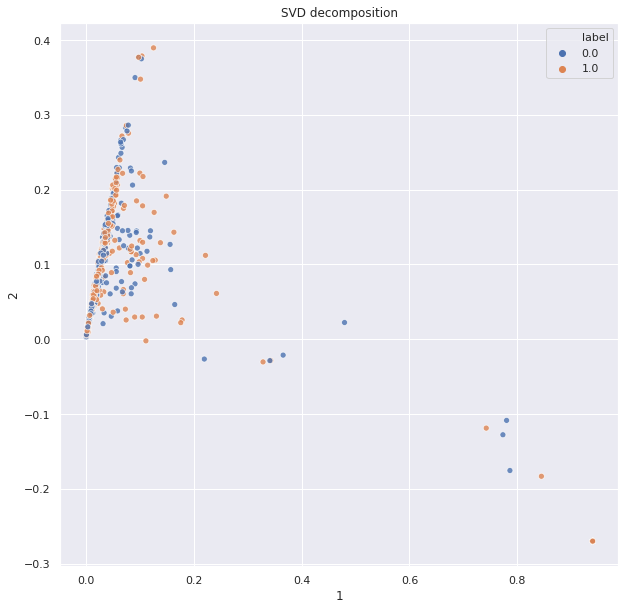

In [16]:
n_components = 2
title = "SVD decomposition"
# Creation of the model
mod = TruncatedSVD(n_components=n_components)
# Fit and transform the features
principal_components = mod.fit_transform(X)

# Put them into a dataframe
df_features = pd.DataFrame(data=principal_components,
                 columns=['1', '2'])

df_features['label'] = y

# Plot
plt.figure(figsize=(10,10))
sns.scatterplot(x='1',
                y='2',
                hue="label", 
                data=df_features,
                alpha=.8).set_title(title);

## Data balancing

In [17]:
if 'smote' in experiment:
    #oversampling with SMOTE
    sm = SMOTE(random_state = 42)
    X_train, y_train = sm.fit_resample(X_train, y_train)
elif 'undersampling' in experiment:
    rus = RandomUnderSampler(random_state = 42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
elif 'random_oversampling' in experiment:
    ros = RandomOverSampler(random_state=42)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    
X_train.shape

(4946, 21173)

In [18]:
vocab_size = X_train.shape[1]
vocab_size

21173

## Metrics

In [19]:
scenario = []
model = []
accuracy_score = []
precision_score = []
recall_score = []
f1_score = []
auc_score = []

## Models training and test

Logistic Regression
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       618
           1       0.74      0.74      0.74       439

    accuracy                           0.78      1057
   macro avg       0.77      0.77      0.77      1057
weighted avg       0.78      0.78      0.78      1057

AUC:  0.8510331659921415


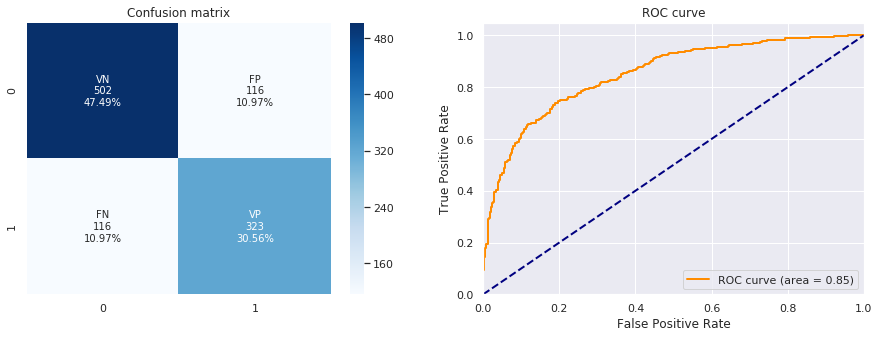

In [20]:
print('Logistic Regression')
logreg = LogisticRegression().fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('logistic regression')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Bernoulli Naive-Bayes
              precision    recall  f1-score   support

           0       0.68      0.95      0.79       618
           1       0.84      0.37      0.51       439

    accuracy                           0.71      1057
   macro avg       0.76      0.66      0.65      1057
weighted avg       0.75      0.71      0.68      1057

AUC:  0.7974434394143796


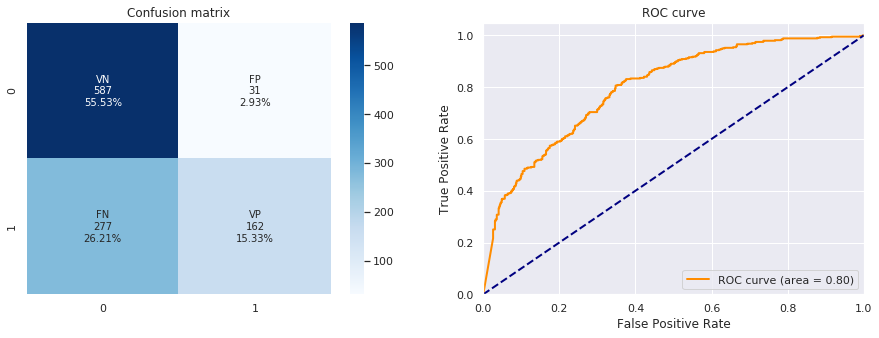

In [21]:
print('Bernoulli Naive-Bayes')
bnb = BernoulliNB().fit(X_train, y_train)
y_pred = bnb.predict(X_test)
y_prob = bnb.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('bernoulli naive-bayes')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Multinomial Naive-Bayes
              precision    recall  f1-score   support

           0       0.89      0.59      0.71       618
           1       0.61      0.89      0.72       439

    accuracy                           0.72      1057
   macro avg       0.75      0.74      0.72      1057
weighted avg       0.77      0.72      0.71      1057

AUC:  0.8545864018695034


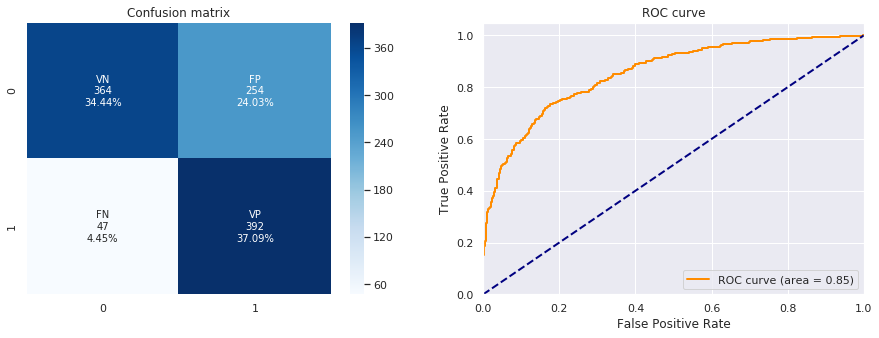

In [22]:
print('Multinomial Naive-Bayes')
mnb = MultinomialNB().fit(X_train, y_train)
y_pred = mnb.predict(X_test)
y_prob = mnb.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('multinomial naive-bayes')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Linear Support Vector Machine
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       618
           1       0.75      0.73      0.74       439

    accuracy                           0.79      1057
   macro avg       0.78      0.78      0.78      1057
weighted avg       0.79      0.79      0.79      1057



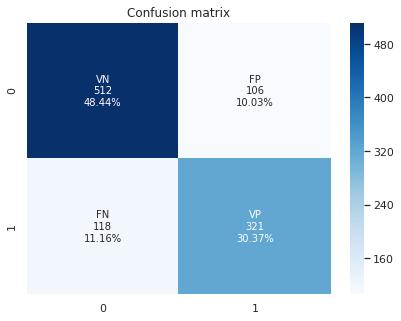

In [23]:
print('Linear Support Vector Machine')
svm = LinearSVC().fit(X_train, y_train)
y_pred = svm.predict(X_test)
#y_prob = svm.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred)

model.append('linear svm')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

KNN
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       618
           1       0.73      0.62      0.67       439

    accuracy                           0.74      1057
   macro avg       0.74      0.73      0.73      1057
weighted avg       0.74      0.74      0.74      1057

AUC:  0.8179243057552101


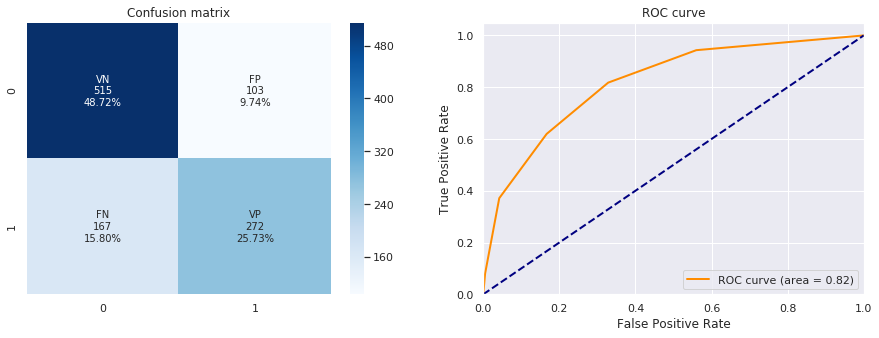

In [24]:
print('KNN')
rf = KNeighborsClassifier().fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('knn')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Random Forest
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       618
           1       0.81      0.64      0.72       439

    accuracy                           0.79      1057
   macro avg       0.80      0.77      0.78      1057
weighted avg       0.79      0.79      0.79      1057

AUC:  0.8567094971655203


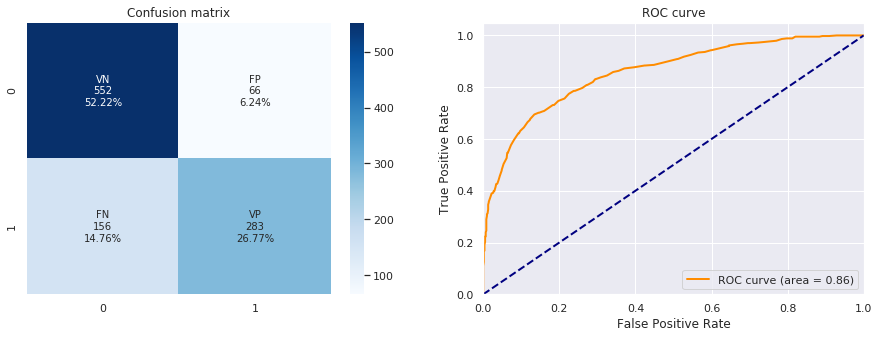

In [25]:
print('Random Forest')
rf = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('random forest')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Gradient Boosting
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       618
           1       0.71      0.64      0.67       439

    accuracy                           0.74      1057
   macro avg       0.74      0.73      0.73      1057
weighted avg       0.74      0.74      0.74      1057

AUC:  0.8073125152044585


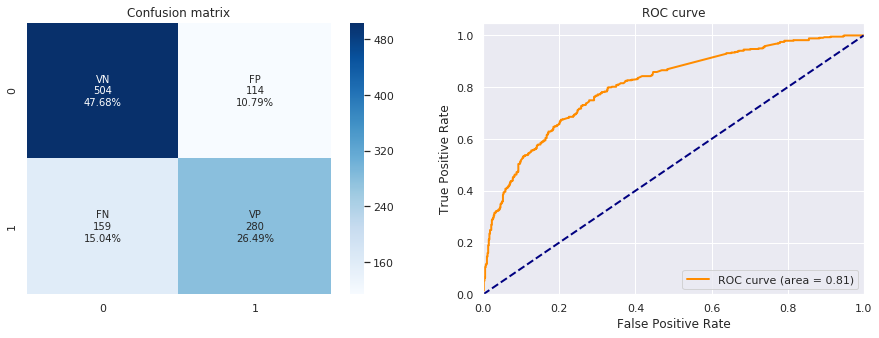

In [26]:
print('Gradient Boosting')
gb = GradientBoostingClassifier().fit(X_train, y_train)
y_pred = gb.predict(X_test)
y_prob = gb.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('gradient boosting')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Multilayer perceptron
Iteration 1, loss = 0.67619944
Validation score: 0.656566
Iteration 2, loss = 0.58561873
Validation score: 0.777778
Iteration 3, loss = 0.47647634
Validation score: 0.797980
Iteration 4, loss = 0.37981726
Validation score: 0.795960
Iteration 5, loss = 0.30489583
Validation score: 0.804040
Iteration 6, loss = 0.24864246
Validation score: 0.804040
Iteration 7, loss = 0.20714344
Validation score: 0.804040
Iteration 8, loss = 0.17524614
Validation score: 0.810101
Iteration 9, loss = 0.15020714
Validation score: 0.808081
Iteration 10, loss = 0.13038264
Validation score: 0.808081
Iteration 11, loss = 0.11406518
Validation score: 0.808081
Iteration 12, loss = 0.10077669
Validation score: 0.810101
Iteration 13, loss = 0.08966187
Validation score: 0.806061
Iteration 14, loss = 0.08036354
Validation score: 0.802020
Iteration 15, loss = 0.07251933
Validation score: 0.804040
Iteration 16, loss = 0.06560315
Validation score: 0.804040
Iteration 17, loss = 0.05979852
Validation 

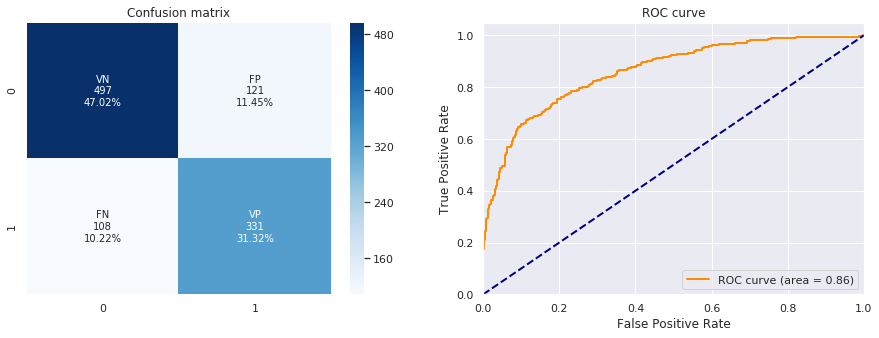

In [27]:
print('Multilayer perceptron')
mlp = MLPClassifier(max_iter = 10, verbose=True, early_stopping= True).fit(X_train, y_train)
y_pred = mlp.predict(X_test)
y_prob = mlp.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('mlp')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

## Results

In [28]:
end_time = time.time()
ellapsed_time = end_time - start_time
print('ellapsed time (min):', ellapsed_time/60)

ellapsed time (min): 0.8494484146436055


In [29]:
df_metrics = pd.DataFrame({'model':model,
                                 'accuracy':accuracy_score,
                                 'precision': precision_score,
                                 'recall': recall_score,
                                 'f1 score': f1_score,
                                 'auc score': auc_score})

df_metrics['vocab'] = [vocab_size]*len(df_metrics)
df_metrics

,model,accuracy,precision,recall,f1 score,auc score,vocab
0,logistic regression,0.780511,0.735763,0.735763,0.735763,0.851033,21173
1,bernoulli naive-bayes,0.708609,0.839378,0.369021,0.512658,0.797443,21173
2,multinomial naive-bayes,0.715232,0.606811,0.892938,0.722581,0.854586,21173
3,linear svm,0.788079,0.751756,0.731207,0.741339,0.000000,21173
4,knn,0.744560,0.725333,0.619590,0.668305,0.817924,21173
5,random forest,0.789972,0.810888,0.644647,0.718274,0.856709,21173
6,gradient boosting,0.741722,0.710660,0.637813,0.672269,0.807313,21173
7,mlp,0.783349,0.732301,0.753986,0.742985,0.860454,21173


In [30]:
filepath = 'results/' + base + '/' + subset + '/ml/' + experiment + '.csv'
filepath

'results/2018/viral/ml/ml-tfidf-processed-random_oversampling.csv'

In [31]:
df_metrics.to_csv(filepath, index = False)

# Error examples with mlp

In [32]:
# 1-1 = 0 true positive
# 0-0 = 0 true negative
# 1-0 = 1 false negative
# 0-1 = -1 false positive
y_pred = mlp.predict(X_test)
y_fails = y_test - y_pred
FN = [index for index, value in enumerate(y_fails) if value == 1]
FP = [index for index, value in enumerate(y_fails) if value == -1]

print('Total test data:', len(y_pred))
print('False negative: ',len(FN))
print('False positive: ',len(FP))

Total test data: 1057
False negative:  108
False positive:  121


In [33]:
full_texts_test = list(full_texts_test)

In [34]:
texts_FN = [full_texts_test[fn] for fn in FN]
texts_FP = [full_texts_test[fp] for fp in FP]

### False negative

In [35]:
for fn in texts_FN:
    print('***')
    print(fn)
    print('***')

***
Gente Apenas Minha Opinião então Vamos lá

No Dia 06 de Junho TSE Derruba o Voto Impresso de Autoria do deputado Federal Candidato a presidente Jair Bolsonaro

No Dia 06 de Setembro Jair Bolsonaro Sofre um Atentado que Seria pra MATAR

Um Dia Antes da Eleição Dia 06; Coincidência Se Juntar as Datas dar Certos 666 
Agora Bolsonaro corre novo Risco...

A que Interessa Isso ? Nova Ordem Mundial / Marconaria ? / iluminati ? / 
Peço que Compartilhem 
E Faca Chegar ao Bolsonaro

Breno Washington MG
Juntos somos fortes
***
***
A morte da velha política no Brasil, comentário de Alexandre Garcia.👇🏻👇🏻👇🏻
***
***
POR ALINE PEREIRA: Republico aqui um post do mês passado, onde conto uma experiência que tive com o Haddad quando ele foi meu professor na USP! E ainda tem gente que pretende votar nele por medo da "ameaça" à democracia representada pelo Bolsonaro! 

...

Dia 11 de setembro de 2001 caiu numa terça-feira, tal como cairá nesse ano...  Eu estava no trabalho quando, pelo portal do UOL, so

### False positives

In [36]:
for fp in texts_FP:
    print()
    print('***')
    print(fp)
    print('***')
    print()


***
TEXTO DA FUNDADORA DO DIRETÓRIO DO PT EM ARACAJU

Esquerda brasileira, chega de apontar culpados! Está na hora de assumir o ocorrido e partir prum mea culpa já!, antes que os Dórias e Bolssonaros assumam o poder! Quem elegeu Temer não foram os coxinhas. Parem de tergiversar. Temer foi eleito por vocês com dinheiro público desviado de hospitais, creches e escolas! O resto é retórica, ou ilação como vocês agora costumam chamar o que nós brasileiros conhecemos como mentira!

A arrogância da esquerda de acreditar que lida com tolos e que porta o Santo Graal está no pano de fundo de sua derrocada mundo afora.

Vamos fazer diferente e lavar a jato essa roupa suja antes que seja tarde! A máscara caiu!

Um homem que responsabiliza a companheira morta para não assumir seus atos é um covarde e não herói . Essa inversão de valores para mim é assustadora...

E não me venham falar da corrupção que existe desde a época de CABRAL que não somos trouxinhas...Nós militamos no PT e construímos esse 


***
No RBS TV RG sul, declararam que ela mesmo fez, mas qual o propósito, por que foi usado contra o Bolsonaro e quem tá por trás desse ato, tão encobrindo todas as  tramas, temos que sabe que saber, doa à quem doer mas se tratando de uma emissora da rede Globo com certeza já tá abafado.
***


***
Boa noite nos da ONG de proteção animal e ambiental estamos pedindo doações para a realização de um bazar quem poder doar por gentileza me contacte no PV ou com Paulão ou ainda com algum membro da ONG  IEPAA grato
***


***
Zé de Abreu: chamou Maria Bethania de 'nordestina feia'

Cuspiu na cara de uma mulher e se vangloriou disso

Ataca publicamente uma colega CONSAGRADA de trabalho só por ter opinião diferente da dele.

Você não vê ninguém da esquerda, nem mesmo os jornalistas, indignados.
***


***
Cansado de justificar porque não voto nos candidatos do PT resolvi apelar para os âncoras do JN. Com a palavra a TV Globo. Peço que divulguem ao máximo essa realidade .
***


***
⛔⛔ Satanás teve

# MLP Hyperparameter tunning with random search

In [41]:
#validation set
X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify = y_train)

In [42]:
def randomLayers():
    '''
    Create a tuple random of hidden_layer_sizes. 
    '''
    n_layers = np.random.randint(1,4)
    layers_list = []
    for i in range(n_layers):            
        hidden_neurons = np.random.randint(10,300)
        layers_list.append(hidden_neurons)
    layers_tuple = tuple(layers_list)
    return layers_tuple

       
print(randomLayers())
    

(151,)


## Hyperparameters

MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)[source].

In [43]:
hyperparams = []
best_hyperpams = []
results = []
n_iter = 20
best_score = 0
np.random.seed(42)

activation_list = ['logistic', 'tanh', 'relu']
solver_list = ['sgd', 'adam', 'lbfgs']
learning_rate_list = ['constant'] #,'adaptive']

for i in range(n_iter):
    print(str(i+1) + '/' + str(n_iter))
    
    # hidden layers
    hidden_layer_sizes = randomLayers()
    
    #activation
    s = np.random.randint(len(activation_list))
    activation = activation_list[s]
    
    #solver
    s = np.random.randint(len(solver_list))
    solver = solver_list[s]
    
    #alpha
    s = np.random.uniform(-4,-0.5)
    alpha = 10**s
    
    #learning rate
    s = np.random.randint(len(learning_rate_list))
    learning_rate = learning_rate_list[s]
    
    # max of iterations during training
    max_iter = np.random.randint(5,20) 
   
    hyperparams.append([hidden_layer_sizes, activation, solver, alpha, learning_rate, max_iter])
    
    print('training: ')
    print(hyperparams[i])
    
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                        activation=activation, 
                        solver=solver, 
                        alpha=alpha, 
                        learning_rate=learning_rate, 
                        max_iter = max_iter,
                        verbose=True, early_stopping= True, 
                        n_iter_no_change = 5).fit(X_train_val, y_train_val)
    
    y_pred = mlp.predict(X_val)
    y_prob = mlp.predict_proba(X_val)[:,1]    
    score = metrics.f1_score(y_val, y_pred, pos_label = 1, average = 'binary')
    results.append(score)
    
    if score > best_score:
        best_score = score
        best_hyperpams = [hidden_layer_sizes, activation, solver, alpha, learning_rate, max_iter]  
        
        
val_data = list(zip(results,hyperparams))    
val_data = sorted(val_data, key=lambda tup: tup[0],reverse = True)
val_data 

1/20
training: 
[(229, 142, 64), 'relu', 'sgd', 0.002440060709081752, 'constant', 14]
Iteration 1, loss = 0.69783335
Validation score: 0.500000
Iteration 2, loss = 0.69783835
Validation score: 0.500000
Iteration 3, loss = 0.69781539
Validation score: 0.500000
Iteration 4, loss = 0.69769626
Validation score: 0.500000
Iteration 5, loss = 0.69755740
Validation score: 0.515695
Iteration 6, loss = 0.69748253
Validation score: 0.531390
Iteration 7, loss = 0.69743379
Validation score: 0.517937
Iteration 8, loss = 0.69742262
Validation score: 0.500000
Iteration 9, loss = 0.69732147
Validation score: 0.529148
Iteration 10, loss = 0.69730105
Validation score: 0.526906
Iteration 11, loss = 0.69733309
Validation score: 0.538117
Iteration 12, loss = 0.69717971
Validation score: 0.524664
Iteration 13, loss = 0.69712519
Validation score: 0.538117
Iteration 14, loss = 0.69708437
Validation score: 0.515695
2/20
training: 
[(232, 111), 'tanh', 'lbfgs', 4.666754684250427e-05, 'constant', 10]


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (14) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


3/20
training: 
[(88, 166, 257), 'logistic', 'sgd', 1.1666608051749357e-05, 'constant', 10]
Iteration 1, loss = 0.69385984
Validation score: 0.500000
Iteration 2, loss = 0.69327870
Validation score: 0.500000
Iteration 3, loss = 0.69441591
Validation score: 0.500000
Iteration 4, loss = 0.69473674
Validation score: 0.500000
Iteration 5, loss = 0.69415684
Validation score: 0.500000
Iteration 6, loss = 0.69412772
Validation score: 0.500000
Iteration 7, loss = 0.69348794
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
4/20
training: 
[(247, 187, 125), 'tanh', 'adam', 0.0005389266009253295, 'constant', 13]
Iteration 1, loss = 0.58517416
Validation score: 0.802691
Iteration 2, loss = 0.19887774
Validation score: 0.816143
Iteration 3, loss = 0.08583198
Validation score: 0.827354
Iteration 4, loss = 0.04611940
Validation score: 0.811659
Iteration 5, loss = 0.04583015
Validation score: 0.807175
Iteration 6, loss = 0.04059275


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.76292641
Validation score: 0.500000
Iteration 2, loss = 0.76179950
Validation score: 0.500000
Iteration 3, loss = 0.76125630
Validation score: 0.500000
Iteration 4, loss = 0.76058083
Validation score: 0.500000
Iteration 5, loss = 0.75992081
Validation score: 0.500000
8/20
training: 
[(93,), 'relu', 'lbfgs', 0.00013412157536967108, 'constant', 14]


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


9/20
training: 
[(84, 267, 106), 'tanh', 'lbfgs', 0.009388917836117824, 'constant', 7]


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


10/20
training: 
[(253,), 'logistic', 'adam', 0.0020738241773250597, 'constant', 7]
Iteration 1, loss = 0.68795957
Validation score: 0.612108
Iteration 2, loss = 0.66551277
Validation score: 0.643498
Iteration 3, loss = 0.65609891
Validation score: 0.645740
Iteration 4, loss = 0.63367287
Validation score: 0.766816
Iteration 5, loss = 0.61991965
Validation score: 0.771300
Iteration 6, loss = 0.60512243
Validation score: 0.704036
Iteration 7, loss = 0.59354636
Validation score: 0.681614
11/20
training: 
[(101,), 'tanh', 'lbfgs', 1.7109272788387533e-05, 'constant', 8]


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (7) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


12/20
training: 
[(244, 136, 237), 'tanh', 'lbfgs', 0.010216531712176236, 'constant', 11]


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


13/20
training: 
[(241, 288, 198), 'relu', 'adam', 3.072435051178286e-05, 'constant', 16]
Iteration 1, loss = 0.65939302
Validation score: 0.773543
Iteration 2, loss = 0.30980674
Validation score: 0.804933
Iteration 3, loss = 0.09974995
Validation score: 0.795964
Iteration 4, loss = 0.04420315
Validation score: 0.804933
Iteration 5, loss = 0.02414772
Validation score: 0.789238
Iteration 6, loss = 0.01816100
Validation score: 0.786996
Iteration 7, loss = 0.01751733
Validation score: 0.780269
Iteration 8, loss = 0.01247451
Validation score: 0.795964
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
14/20
training: 
[(221, 240, 161), 'relu', 'adam', 6.07027532893689e-05, 'constant', 5]
Iteration 1, loss = 0.66435644
Validation score: 0.782511
Iteration 2, loss = 0.35023661
Validation score: 0.818386
Iteration 3, loss = 0.11480872
Validation score: 0.816143
Iteration 4, loss = 0.04673279
Validation score: 0.811659
Iteration 5, loss = 0.02859981
Val

/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


16/20
training: 
[(223, 243, 120), 'relu', 'sgd', 4.899139688863978e-05, 'constant', 14]
Iteration 1, loss = 0.69425440
Validation score: 0.500000
Iteration 2, loss = 0.69393107
Validation score: 0.500000
Iteration 3, loss = 0.69372292
Validation score: 0.500000
Iteration 4, loss = 0.69341734
Validation score: 0.506726
Iteration 5, loss = 0.69339995
Validation score: 0.491031
Iteration 6, loss = 0.69334481
Validation score: 0.504484
Iteration 7, loss = 0.69330899
Validation score: 0.504484
Iteration 8, loss = 0.69324698
Validation score: 0.495516
Iteration 9, loss = 0.69324792
Validation score: 0.500000
Iteration 10, loss = 0.69322301
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
17/20
training: 
[(276, 247, 298), 'logistic', 'sgd', 0.044356922319551566, 'constant', 16]
Iteration 1, loss = 0.73658217
Validation score: 0.500000
Iteration 2, loss = 0.73636798
Validation score: 0.500000
Iteration 3, loss = 0.73553757

/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.70077638
Validation score: 0.500000
Iteration 2, loss = 0.69375773
Validation score: 0.500000
Iteration 3, loss = 0.69357299
Validation score: 0.500000
Iteration 4, loss = 0.69339696
Validation score: 0.500000
Iteration 5, loss = 0.69470968
Validation score: 0.500000
Iteration 6, loss = 0.69526733
Validation score: 0.500000
Iteration 7, loss = 0.69381478
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
20/20
training: 
[(167, 86), 'relu', 'sgd', 0.013313349230514797, 'constant', 9]
Iteration 1, loss = 0.71271625
Validation score: 0.500000
Iteration 2, loss = 0.71184484
Validation score: 0.500000
Iteration 3, loss = 0.71098141
Validation score: 0.500000
Iteration 4, loss = 0.71051049
Validation score: 0.500000
Iteration 5, loss = 0.70998660
Validation score: 0.500000
Iteration 6, loss = 0.70967707
Validation score: 0.500000
Iteration 7, loss = 0.70936072
Validation score: 0.500000
Validation scor

[(0.8266129032258065,
  [(221, 240, 161), 'relu', 'adam', 6.07027532893689e-05, 'constant', 5]),
 (0.8265107212475633,
  [(253,), 'logistic', 'adam', 0.0020738241773250597, 'constant', 7]),
 (0.8233082706766918,
  [(247, 187, 125), 'tanh', 'adam', 0.0005389266009253295, 'constant', 13]),
 (0.8226120857699804,
  [(241, 288, 198), 'relu', 'adam', 3.072435051178286e-05, 'constant', 16]),
 (0.7887323943661971,
  [(93,), 'relu', 'lbfgs', 0.00013412157536967108, 'constant', 14]),
 (0.7870182555780932,
  [(244, 136, 237), 'tanh', 'lbfgs', 0.010216531712176236, 'constant', 11]),
 (0.7484909456740442,
  [(101,), 'tanh', 'lbfgs', 1.7109272788387533e-05, 'constant', 8]),
 (0.7352941176470588,
  [(232, 111), 'tanh', 'lbfgs', 4.666754684250427e-05, 'constant', 10]),
 (0.7230443974630021,
  [(181, 251), 'tanh', 'lbfgs', 0.017467213744690267, 'constant', 7]),
 (0.6987270155586986,
  [(278, 137), 'logistic', 'adam', 1.5423946513482075e-05, 'constant', 6]),
 (0.6900420757363253,
  [(84, 267, 106), 'tan

In [44]:
#best_hyperpams = [hidden_layer_sizes, activation, solver, alpha, learning_rate, max_iter]
hidden_layer_sizes = best_hyperpams[0]
activation = best_hyperpams[1]
solver = best_hyperpams[2]
alpha = best_hyperpams[3]
learning_rate = best_hyperpams[4]
max_iter = best_hyperpams[5]
best_hyperpams

[(221, 240, 161), 'relu', 'adam', 6.07027532893689e-05, 'constant', 5]

In [45]:
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                    activation=activation, 
                    solver=solver, 
                    alpha=alpha, 
                    learning_rate=learning_rate, 
                    max_iter = max_iter,
                    verbose=True, early_stopping= True, 
                    n_iter_no_change = 5).fit(X_train, y_train)

Iteration 1, loss = 0.64516303
Validation score: 0.783838
Iteration 2, loss = 0.28642960
Validation score: 0.818182
Iteration 3, loss = 0.09616290
Validation score: 0.814141
Iteration 4, loss = 0.04225275
Validation score: 0.810101
Iteration 5, loss = 0.02474035
Validation score: 0.808081


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.82      0.81      0.81       618
           1       0.74      0.74      0.74       439

    accuracy                           0.78      1057
   macro avg       0.78      0.78      0.78      1057
weighted avg       0.78      0.78      0.78      1057

AUC:  0.8583497357188667


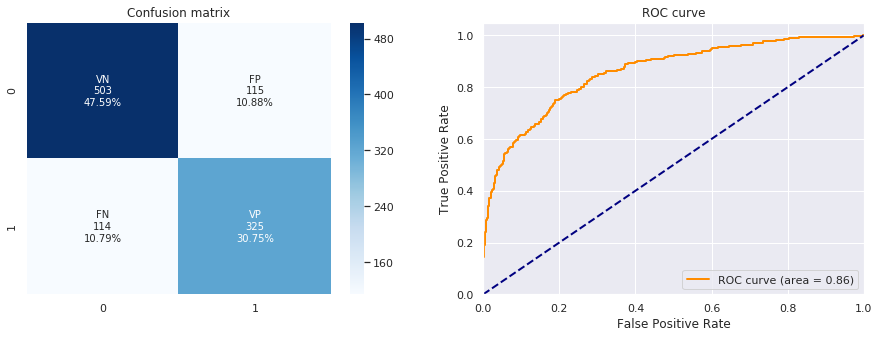

In [46]:
y_pred = mlp.predict(X_test)
y_prob = mlp.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

In [47]:
print([acc, precision, recall, f1, roc_auc])

[0.783349101229896, 0.7386363636363636, 0.7403189066059226, 0.7394766780432309, 0.8583497357188667]
